In [8]:
# Import necessary libraries for data manipulation, visualization, and machine learning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import yfinance as yf
import seaborn as sns
import tensorflow as tf
import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [15]:
def sigmoid_activation(x):
    """
    Compute the sigmoid activation function.

    Args:
        x: Input value
        
    Returns:
        float: Sigmoid activation value between 0 and 1
    """
    return 1 / (1 + np.exp(-x))

In [16]:
class LSTM_Algo:
    """
    LSTM-based trading algorithm for financial market prediction and trading simulation.
    
    Attributes:
        ticker (str): Stock ticker symbol
        start_date (str): Start date for historical data
        end_date (str): End date for historical data
        initial_portfolio (float): Initial investment amount
        max_risk (float): Maximum risk percentage per trade
        correlation_long (int): Long-term correlation period
        correlation_short (int): Short-term correlation period
        moving_average_period (int): Period for moving average calculation
    """
    
    def __init__(self, ticker, start_date, end_date, initial_portfolio, max_risk, corr_long, corr_short, mov_avg_per):
        # Initialize class attributes
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.initial_portfolio = initial_portfolio
        self.max_risk = max_risk
        self.corr_long = corr_long
        self.corr_short = corr_short
        self.mov_avg_per = mov_avg_per
        
    def getData(self):
        """
        Fetch and preprocess historical market data.
        
        Returns:
            pd.DataFrame: Processed market data with technical indicators
        """
        
        # Fetch historical data from Yahoo Finance
        start = self.start_date
        end = self.end_date
        ma = self.mov_avg_per
        corr_per_short = self.corr_short 
        corr_per_long = self.corr_long
        target = self.ticker
        ticker_list = [target]
        df = pd.DataFrame()
        
        # Add calculated technical indicators to the dataframe
        for i in range(len(ticker_list)):
            ticker = ticker_list[i]
            if(ticker != target):
                data = yf.Ticker(ticker).history(start = start, end = end)[['Open', 'Close']]
                df[f'{ticker} Prev Log Ret'] = np.log(data['Close'].shift(1)/data['Close'].shift(2)).values
                df[f'{ticker} Open'] = data['Open'].values
                df[f'{ticker} MA'] = data['Close'].rolling(ma).mean().shift(1).values
                df[f'{target} Prev Close'] = data['Close'].shift(1).values
            else:
                data = yf.Ticker(ticker).history(start = start, end = end)[['Open', 'Close', 'Volume']]
             #   df[f'{target} 3-50 Volume'] = data['Volume'].shift(1)
                df[f'{ticker} Prev Log Ret'] = np.log(data['Close'].shift(1)/data['Close'].shift(2)).values
                df[f'{ticker} Open'] = data['Open'].values
                df[f'{ticker} MA'] = data['Close'].shift(1).rolling(ma).mean().values
                df[f'{target} Prev Close'] = data['Close'].shift(1).values
                df[f'{target} Prev Volume'] = data['Volume'].shift(1).values
                df[f'{target} Close'] = data['Close'].values
        
        # Drop rows with missing data
        df = df.dropna()
        
        return df
    
    def getTestTraining(self):
        """
        Prepare and scale training and testing datasets.
        
        Returns:
            tuple: Scaled training and testing data (trainX, trainY, testX, testY)
        """
        target = self.ticker
        df = self.getData()
        n = len(df)
        prop_train = 0.8
        len_train = int(np.floor(prop_train*n))

        # Split data into training and testing sets
        train_df = df[0:len_train]
        test_df = df[len_train:]
        
        # Separate features and target variable
        train_df_X = train_df.drop([f'{target} Close'], axis = 1)
        test_df_X = test_df.drop([f'{target} Close'], axis = 1)

        train_df_y = train_df[f'{target} Close']
        test_df_y = test_df[f'{target} Close']

        trainY = train_df_y.values
        testY = test_df_y.values

        # Scale features to [0, 1] range
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaler.fit(train_df_X)
        trainX = scaler.transform(train_df_X)
        testX = scaler.transform(test_df_X)

        # Reshape for LSTM input
        trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
        testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
        
        return trainX,trainY,testX,testY
            
            
    def train_or_retreive(self):
        """
        Train a new LSTM model or load an existing one.
        
        Returns:
            keras.Model: Trained LSTM model
        """
        
        target = self.ticker
        try:
            # Load existing model if available
            model = keras.models.load_model(f'{target}_LSTM_Model.keras')
        except:
            # Otherwise, train a new model
            trainX,trainY,testX,testY = self.getTestTraining()
            model = Sequential()
            units = int(350)
            epochs = int(250)
            model.add(LSTM(units))
            model.add(Dense(1))
            model.compile(loss = 'mean_squared_error', optimizer = 'adamax')
            model.fit(trainX, trainY, epochs=epochs, verbose = 1)
            model.save(f'{target}_LSTM_Model.keras')
        model = keras.models.load_model(f'{target}_LSTM_Model.keras')
        
        return model
            
    def backtestModelPlot(self):
        """
        Perform backtesting of the LSTM model and visualize results.
        
        Returns:
            tuple: Statistics about buying/selling (buy_count, sell_count, buy_wins, sell_wins, max_risk_taken)
        """
        
        # Initialize variables
        transaction_cost = 0.0005
        model = self.train_or_retreive()
        initial = self.initial_portfolio
        max_alloc = self.max_risk
        target = self.ticker
        df = self.getData()

        model = self.train_or_retreive()
        n = len(df)
        prop_train = 0.8
        len_train = int(np.floor(prop_train*n))

        train_df = df[0:len_train]
        test_df = df[len_train:]

        train_df_X = train_df.drop([f'{target} Close'], axis = 1)
        test_df_X = test_df.drop([f'{target} Close'], axis = 1)

        train_df_y = train_df[f'{target} Close']
        test_df_y = test_df[f'{target} Close']

        trainY = train_df_y.values
        testY = test_df_y.values
        
        # Get test data and predictions
        trainX = self.getTestTraining()[0]
        testX = self.getTestTraining()[2]

        # Calculate predicted and actual returns
        trading_df = pd.DataFrame()
        trading_df['Actual'] = test_df_y.values
        trading_df['Predicted'] = model.predict(testX)
        trading_df['Actual PCT Change'] = trading_df['Actual'].pct_change()
        trading_df['Predicted PCT Change'] = trading_df['Predicted'].pct_change()
        trading_df = trading_df.dropna()

        # Run backtest
        pnl = initial
        pnl_A = []
        prices = trading_df['Actual'].values
        predReturns = trading_df['Predicted PCT Change'].values
        buy =  [0]
        sell = [0]
        buy_count = 0
        sell_count = 0
        buy_win = 0
        sell_win = 0
        max_risk = 0
        for i in range(1,len(trading_df)):
            # Calculate maximum shares based on portfolio and predicted risk
            predReturn = predReturns[i]
            max_shares = np.floor(max_alloc*pnl/prices[i-1])
            proportion = sigmoid_activation(np.abs(predReturn)**0.05)
            acc_no_shares = np.floor(proportion*max_shares)
            
            # Track maximum risk
            if(acc_no_shares*prices[i-1]/pnl > max_risk):
                max_risk = acc_no_shares*prices[i-1]/pnl
            # Simulate buy or sell based on predicted price movement
            if(predReturn > 0):  # Buy
                pnl += acc_no_shares*((1-transaction_cost)*prices[i] -(1+transaction_cost)*prices[i-1])
                pnl_A.append(pnl)
                buy.append(prices[i-1])
                sell.append(0)
                buy_count += 1
                if(acc_no_shares*((1-transaction_cost)*prices[i] -(1+transaction_cost)*prices[i-1]) > 0):
                    buy_win += 1
            elif(predReturn < 0):  # Sell
                pnl -=acc_no_shares*((1+transaction_cost)*prices[i] - (1-transaction_cost)*prices[i-1])
                pnl_A.append(pnl)
                sell.append(prices[i-1])
                buy.append(0)
                sell_count += 1
                if(acc_no_shares*((1+transaction_cost)*prices[i] - (1-transaction_cost)*prices[i-1]) < 0):
                    sell_win += 1
            else:
                buy.append(0)
                sell.append(0)
                pnl_A.append(pnl)

        # Plot results
        plt.figure(figsize = (16,6))
        plt.plot(np.roll(prices,1)[5:], label = 'Prices')
        plt.plot(buy[5:], marker = '^', color = 'g', linestyle = 'None', markersize = 3.3, label = 'Buy')
        plt.plot(sell[5:], marker = 'v', color = 'r', linestyle = 'None', markersize = 3.3, label = 'Sell')
        plt.ylim(0.95*np.min(prices), 1.05*np.max(prices))
        plt.show()

        plt.figure(figsize = (16,6))
        plt.plot(pnl_A)
        plt.title(f'P&L of Algo')
        plt.show()
        
        return buy_count, sell_count, buy_win, sell_win, max_risk
            
    def algo_pnl(self):
        """
        Calculate profit and loss metrics for the trading strategy.
        
        Returns:
            tuple: Arrays of total P&L, long-only P&L, and short-only P&L
        """
        
        # Initialize variables
        cost_of_trading = 0.000
        model = self.train_or_retreive()
        initial = self.initial_portfolio
        max_alloc = self.max_risk
        target = self.ticker
        df = self.getData()

        model = self.train_or_retreive()
        n = len(df)
        prop_train = 0.8
        len_train = int(np.floor(prop_train*n))

        train_df = df[0:len_train]
        test_df = df[len_train:]

        train_df_X = train_df.drop([f'{target} Close'], axis = 1)
        test_df_X = test_df.drop([f'{target} Close'], axis = 1)

        train_df_y = train_df[f'{target} Close']
        test_df_y = test_df[f'{target} Close']

        trainY = train_df_y.values
        testY = test_df_y.values

        # Get test data and predictions
        trainX = self.getTestTraining()[0]
        testX = self.getTestTraining()[2]

        # Create a DataFrame to store actual and predicted price changes
        trading_df = pd.DataFrame()
        trading_df['Actual'] = test_df_y.values
        trading_df['Predicted'] = model.predict(testX)
        trading_df['Actual PCT Change'] = trading_df['Actual'].pct_change()
        trading_df['Predicted PCT Change'] = trading_df['Predicted'].pct_change()
        trading_df = trading_df.dropna()

        # Initialize variables for P&L calculation
        acc = trading_df['Actual PCT Change'].values
        pnl = initial
        pnl_A = []
        pnlBb = 0
        pnlSs = 0
        pnlB = []
        pnlS = []
        prices = trading_df['Actual'].values
        predReturns = trading_df['Predicted PCT Change'].values
        buy =  []
        sell = []

        for i in range(1,len(trading_df)):
            ac = acc[i]
            predReturn = predReturns[i]
            max_shares = np.floor(max_alloc*pnl/prices[i-1])
            proportion = sigmoid_activation(np.abs(predReturn)**0.05)
            acc_no_shares = np.floor(proportion*max_shares)
            
            # Calculate P&L for buy (long) trades
            if(predReturn > 0):
                pnl += acc_no_shares*((1-cost_of_trading)*prices[i] - (1+cost_of_trading)*prices[i-1])
                pnlBb += acc_no_shares*((1-cost_of_trading)*prices[i] - (1+cost_of_trading)*prices[i-1])
                pnlB.append(pnlBb)
                pnlS.append(pnlSs)
                pnl_A.append(pnl)
            # Calculate P&L for sell (short) trades
            elif(predReturn < -0*cost_of_trading):
                pnl -= acc_no_shares*((1+cost_of_trading)*prices[i] - (1-cost_of_trading)*prices[i-1])
                pnlSs -= acc_no_shares*((1+cost_of_trading)*prices[i] - (1-cost_of_trading)*prices[i-1])
                pnlS.append(pnlSs)
                pnlB.append(pnlBb)
                pnl_A.append(pnl)
            else:
                buy.append(0)
                sell.append(0)
                pnlB.append(pnlBb)
                pnlS.append(pnlSs)
                pnl_A.append(pnl)
                
        return pnl_A, pnlB, pnlS
    
    def algoReturns(self):
        """Calculate algorithm returns."""
        return np.diff(self.algo_pnl()[0])
    
    def algoReturnsDist(self):
        """Plot distribution of algorithm returns in dollars."""
        plt.figure()
        sns.kdeplot(self.algoReturns())
        plt.title('Distribution of Returns ($)')
        
    def algoPCTReturns(self):
        """Calculate percentage returns of the algorithm."""
        return pd.Series(self.algoReturns()[0]).pct_change().dropna().values
    
    def algoPCTReturnsDist(self):
        """Plot distribution of algorithm returns in percentage."""
        plt.figure()
        sns.kdeplot(self.algoPCTReturns())
        plt.title('Distribution of Returns (%)')
        
    def algoMonthlyRollingDev(self):
        """Calculate monthly rolling standard deviation."""
        d1 = pd.Series(self.algoReturns()[0]).pct_change().dropna().rolling(30).mean()
        d2 = np.std(d1)
        return d2
    
    def LongShortPNLDist(self):
        """Plot distribution of long and short position P&L."""
        pnlB1 = self.algo_pnl()[1]
        pnlB = pd.Series(pnlB1).pct_change().dropna().values
        pnlS1 = self.algo_pnl()[2]
        pnlS = pd.Series(pnlS1).pct_change().dropna().values
        
        plt.figure()
        sns.kdeplot(pnlB, label = f'Buy, $mu$={round(np.mean(pnlB),2)}')
        sns.kdeplot(pnlS, label = f'Sell, $mu$={round(np.mean(pnlS),2)}')
        plt.legend()
        plt.title('Distribution of Returns (L/S) of Algo')
        plt.show()
        
    def printStats(self):
        """Print comprehensive trading statistics."""
        buy_count, sell_count, buy_win, sell_win, max_risk = self.backtestModelPlot()
        max_prof = np.max(np.diff(self.algo_pnl()[0]))
        max_loss = np.min(np.diff(self.algo_pnl()[0]))
        i = np.argmin(np.diff(self.algo_pnl()[0]))
        val = self.algo_pnl()[0][i]
        dol_sig = np.std(np.diff(self.algo_pnl()[0]))
        pct_sig = np.std(pd.Series(self.algo_pnl()[0]).pct_change().dropna().values)
        avg_daily_ret = np.mean(np.diff(self.algo_pnl()[0]))
        avg_pct_ret = pd.Series(self.algo_pnl()[0]).pct_change().dropna().mean()
        pct_ret = round(100*(self.algo_pnl()[0][-1:][0] - self.initial_portfolio)/self.initial_portfolio,2) 
        dol_ret = round(self.algo_pnl()[0][-1:][0] - self.initial_portfolio,2)
        ann_ret = (1+(self.algo_pnl()[0][-1:][0] - self.initial_portfolio)/self.initial_portfolio)**(252/len(self.getTestTraining()[3]))-1
        avg_pct_trade = pd.Series(self.algo_pnl()[0]).pct_change().dropna().sum()/(buy_count+sell_count)
        print('* Initial Set-Up *')
        print(f'Initial Capital Allocation: ${self.initial_portfolio:,}')
        print(f'Hard Capped Maximum Allocaiton to a Single Trade: {round(100*self.max_risk,2)}%')
        print(f'Length of Training/Testing Data: {len(self.getTestTraining()[1])}/{len(self.getTestTraining()[3])}')
        print('')
        print('* Quick Stats *')
        print(f'Final Dollar P&L: ${dol_ret:,}')
        print(f'Final Percentage P&L: {pct_ret}%')
        print(f'Annualised Returns: {round(100*ann_ret,2)}%')
        print(f'Upper Bounded Dollar Sharpe: {round((avg_daily_ret)*np.sqrt(252)/dol_sig,2)}')
        print(f'Upper Bounded %age Sharpe: {round((avg_pct_ret)*np.sqrt(252)/pct_sig,2)}')
        print(f'%age Sharpe vs 5% Rates: {round((avg_pct_ret-0.0001)*np.sqrt(252)/pct_sig,2)}')
        print(f'Average Daily Dollar Returns: ${round(avg_daily_ret,2)}')
        print(f'Average Daily Percentage Returns: {round(100*avg_pct_ret,2)}%')
        print(f'Best Profit in a Single Trade: ${round(max_prof,2)}')
        print(f'Worst Loss in a Single Trade: ${round(max_loss,2)} ({round(100*max_loss/val,2)}%)')
        print(f'Max Bet on a Single Trade: {round(100*max_risk,2 )}%')
        print('')
        print('* Long/Short Stats *')
        print(f'Number of Trades Made: {buy_count + sell_count}')
        print(f'Number of Trades Won: {buy_win + sell_win}/{buy_count + sell_count} ({round(100*(buy_win + sell_win)/(buy_count + sell_count),2)}%)')
        print(f'Average %age return of a trade: {round(100*avg_pct_trade,2)}%')
        print(f'Annualised Standard Deviation of Percentage Return: {round(pct_sig*np.sqrt(252),2)}')
        print(f'Percentage long: {round(100*buy_count/(buy_count+sell_count),2)}, percentage short: {round(100*sell_count/(buy_count+sell_count),2)} ')
        print(f'Percentage long won: {round(100*buy_win/buy_count,2)}, percentage short won: {round(100*sell_win/sell_count,2)}')

 1/21 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step

/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


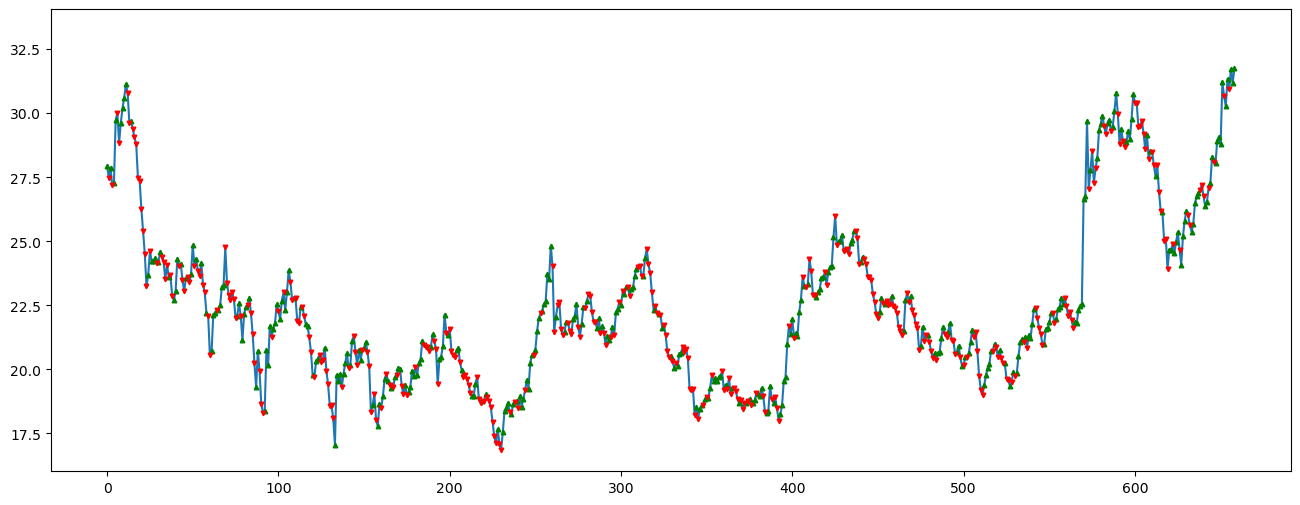

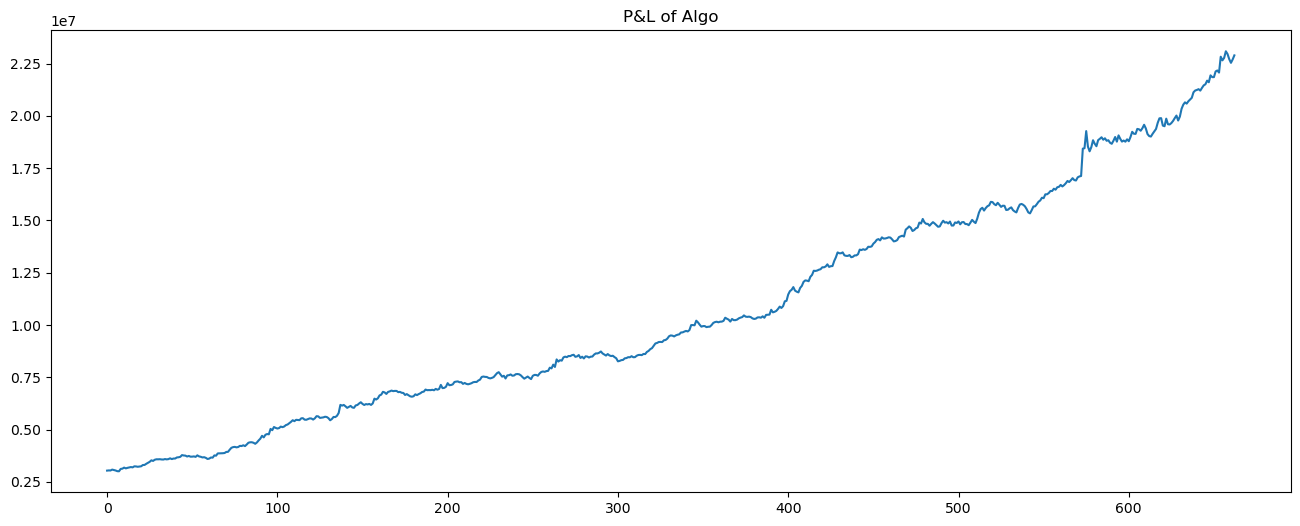

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

* Initial Set-Up *
Initial Capital Allocation: $3,000,000.0
Hard Capped Maximum Allocaiton to a Single Trade: 60.0%
Length of Training/Testing Data: 2660/665

* Quick Stats *
Final Dollar P&L: $27,086,156.73
Final Percentage P&L: 902.87%
Annualised Returns: 139.56%
Upper Bounded Dollar Sharpe: 4.36
Upper Bounded %age Sharpe: 5.41
%age Sharpe vs 5% Rates: 5.25
Average Daily Dollar Returns: $40852.63
Average Daily Percentage Returns: 0.35%
Best Profit in a Single Trade: $1665387.35
Worst Loss in a Single Trade: $-927125.49 (-3.79%)
Max Bet on a Single Trade: 42.7%

* Long/Short Stats *
Number of Trades Made: 663
Number of Trades Won: 413/663 (62.29%)
Average %age return of a trade: 0.35%
Annualised Standard Deviation of Percentage Return: 0.16
Percentage long: 50.23, percentage short: 49.77 
Percentage long won: 63.96, percentage short won: 60.61


/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

In [17]:
# Instantiate the LSTM_Algo class with specific parameters
tick = LSTM_Algo('SFTBY', '2010-01-01', '2024-06-18', 3e6, 0.60, 31, 5, 30)

# Print the statistics of the trading strategy
tick.printStats()

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

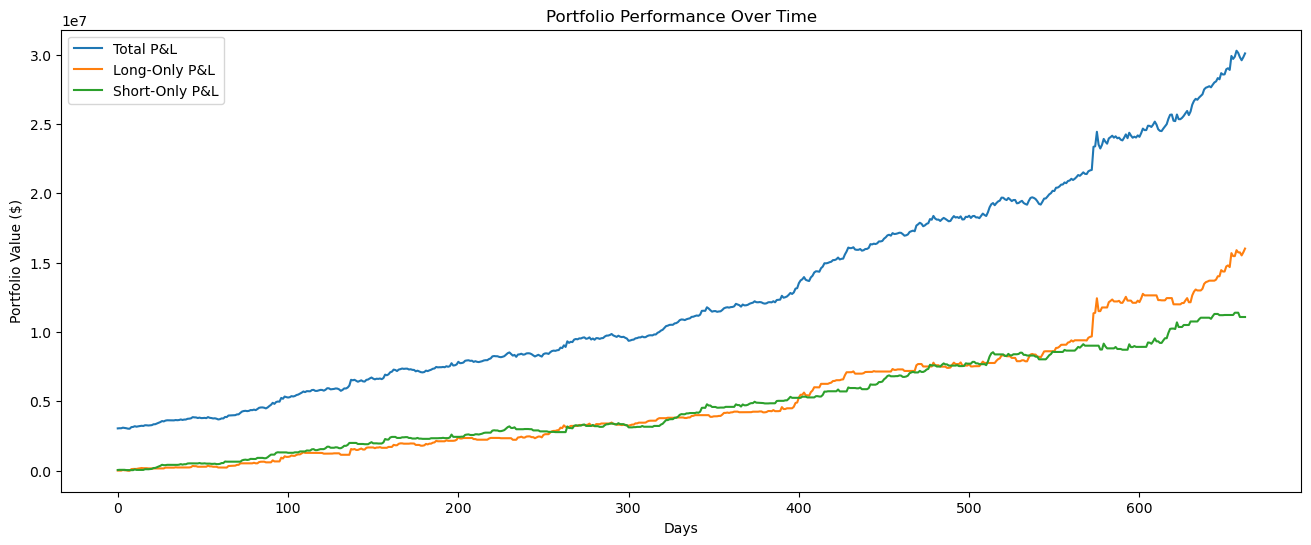

In [18]:
# Plot P&L for the algorithm
plt.figure(figsize=(16, 6))
plt.plot(tick.algo_pnl()[0], label='Total P&L')
plt.plot(tick.algo_pnl()[1], label='Long-Only P&L')
plt.plot(tick.algo_pnl()[2], label='Short-Only P&L')
plt.title('Portfolio Performance Over Time')
plt.xlabel('Days')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.show()

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

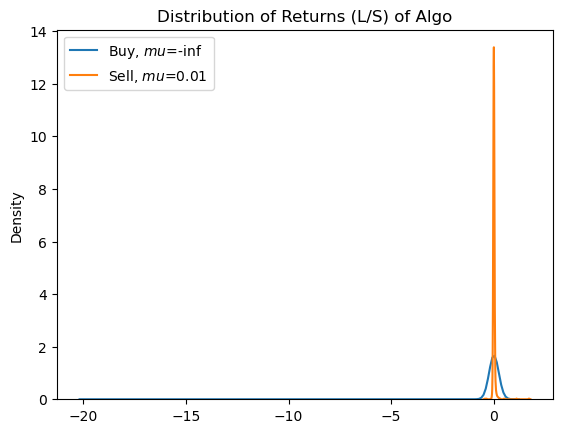

In [19]:
# Plot the distribution of P&L for long and short trades
tick.LongShortPNLDist()

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

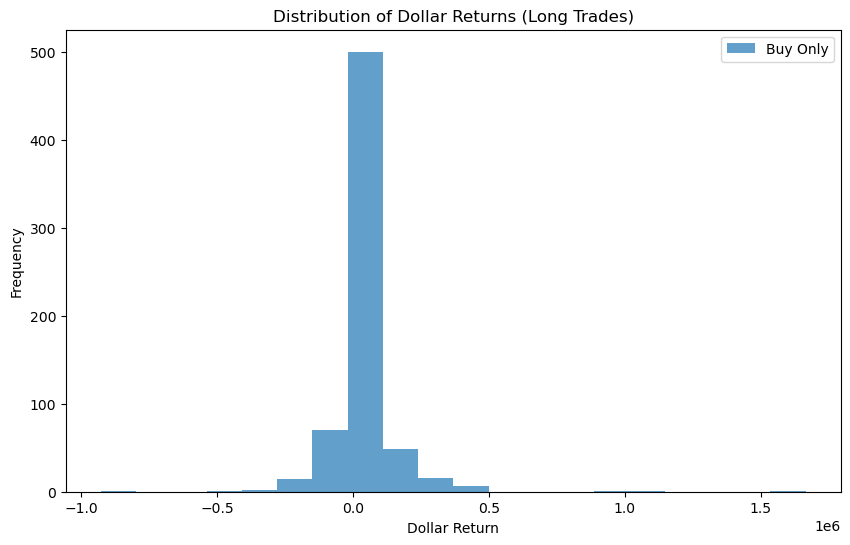

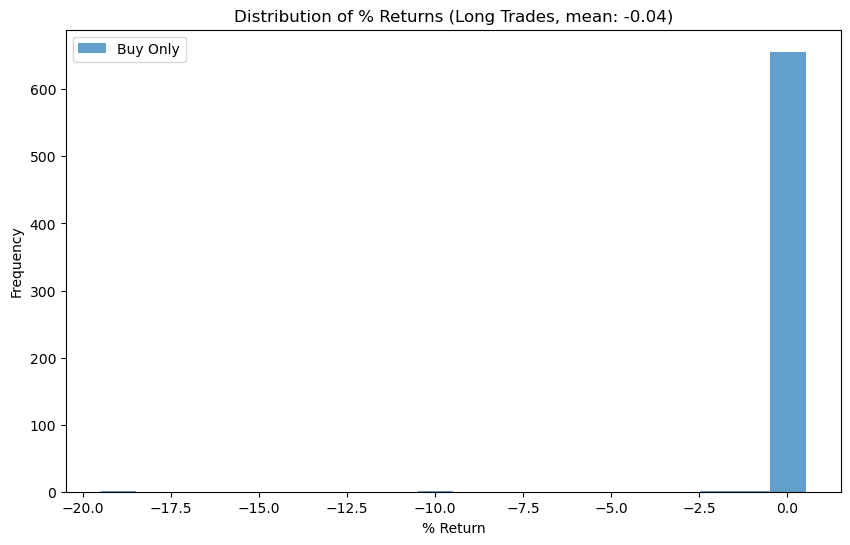

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

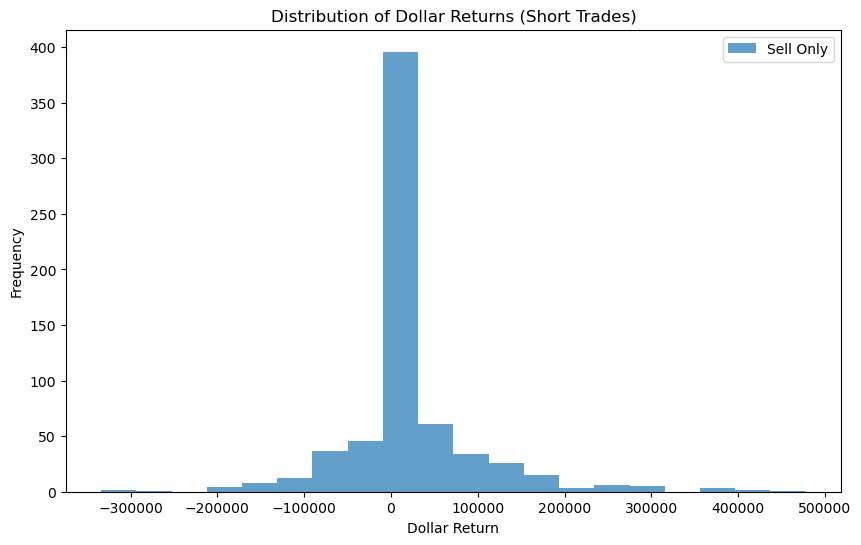

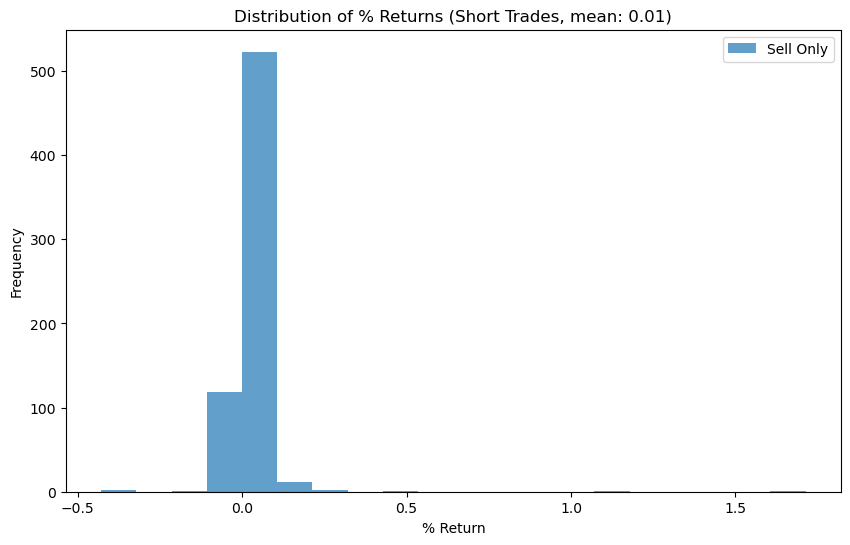

In [20]:
# Analyze and plot the distribution of dollar and percentage returns for long trades
pnlBuy = tick.algo_pnl()[1]

plt.figure(figsize=(10, 6))
plt.title('Distribution of Dollar Returns (Long Trades)')
plt.hist(np.diff(pnlBuy), bins=20, label='Buy Only', alpha=0.7)
plt.xlabel('Dollar Return')
plt.ylabel('Frequency')
plt.legend()
plt.show()

pctBuy = pd.Series(pnlBuy).pct_change().dropna().values[1:]
plt.figure(figsize=(10, 6))
plt.title(f'Distribution of % Returns (Long Trades, mean: {np.mean(pctBuy):.2f})')
plt.hist(pctBuy, bins=20, label='Buy Only', alpha=0.7)
plt.xlabel('% Return')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Analyze and plot the distribution of dollar and percentage returns for short trades
pnlSell = tick.algo_pnl()[2]

plt.figure(figsize=(10, 6))
plt.title('Distribution of Dollar Returns (Short Trades)')
plt.hist(np.diff(pnlSell), bins=20, label='Sell Only', alpha=0.7)
plt.xlabel('Dollar Return')
plt.ylabel('Frequency')
plt.legend()
plt.show()

pctSell = pd.Series(pnlSell).pct_change().dropna().values[1:]
plt.figure(figsize=(10, 6))
plt.title(f'Distribution of % Returns (Short Trades, mean: {np.mean(pctSell):.2f})')
plt.hist(pctSell, bins=20, label='Sell Only', alpha=0.7)
plt.xlabel('% Return')
plt.ylabel('Frequency')
plt.legend()
plt.show()